In [1]:
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset,OutputVis, CreatePlotsRPD
from detectron2.utils.colormap import random_color

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use('ybpres.mplstyle')
import pandas as pd


In [ ]:
dataset_name = "test"
has_annotations=True
dfimg = pd.read_csv('output_test/dfimg_test.csv',index_col=0)
dfvol = dfimg.groupby(['ptid','eye']).sum()
vols = dfvol[dfvol.dt_instances>=5].index
grps = dfimg[dfimg.set_index(['ptid','eye']).index.isin(vols)].groupby(['ptid','eye'])
#spacing
D = 5760 #um
d = D/48 #um scan spacing

P = 1024 #px scan width in pixels = D
dpx = d*P/D #px scan spacing in pixels

In [2]:
dataset_name = "dfeval_train_v2"
has_annotations = False
dfimg = pd.read_csv('output_dfeval_train_v2/dfimg_dfeval_train_v2.csv',index_col=0)
dfvol = dfimg.groupby(['volID']).sum()
vols = dfvol[dfvol.dt_instances>=20].index
grps = dfimg[dfimg.volID.isin(vols)].groupby(['volID'])
#spacing
d = 121.171 #um scan spacing
D = d*60 #um height of the enface area

P = 768 #px scan width in pixels

dpx = d/11.233 #px scan spacing in pixels

In [3]:

DatasetCatalog.register(dataset_name, grab_dataset(dataset_name))
MetadataCatalog.get(dataset_name).thing_classes = [""]
vis =OutputVis(dataset_name,pred_mode='file',pred_file = 'output_'+dataset_name+'/coco_instances_results.json',has_annotations=has_annotations)

## En face instance visualization

In [ ]:

def mygen(grps):
    for name,grp in grps:
        grp = grps.get_group(name).sort_index()
        yield vis.compare_enface(grp,name,496,P,dpx)
  

gen = mygen(grps)

# Longitudnal Study #

In [4]:

dfdata = pd.read_parquet('datasets/dfeval_train_v2_refined.parquet')
dfdata[(dfdata.instance.isin(vols))&(dfdata.slicei==0)].groupby(['ptid','eye']).count()
ptid = '477daf788b31a095c03f5846a5e738dc4800bd8a6679e301b68c051505648b8d'
vols_L = dfdata[(dfdata.ptid==ptid)&(dfdata.eye=='L')][['instance','age','octh','slicei']]
vols_R = dfdata[(dfdata.ptid==ptid)&(dfdata.eye=='R')][['instance','age','octh','slicei']]
grps_L = dfimg.reset_index().merge(vols_L, left_on=['volID','scan'],right_on=['instance','slicei']).set_index('index').drop(columns=['instance','slicei']).groupby(['age'])
grps_R = dfimg.reset_index().merge(vols_R, left_on=['volID','scan'],right_on=['instance','slicei']).set_index('index').drop(columns=['instance','slicei']).groupby(['age'])

In [5]:
def draw_enface_dt(vis,ax,grp,scan_height,scan_width,plot_color,affine_matrix=None):
    """Return enface perspective of model predictions for a single scan volume whose imgids are listed in the index of grp.

    Args:
        grp (pandas.DataFrame): Dataframe containing images from a single scan volume indexed by ImageId.
        scan_height (int): Image height in pixels.
        scan_width (int): Image width in pixels.
        scan_spacing (float): The spacing between scan centers in pixels.

    Returns:
        np.array: Numpy array of dimension [scan_spacing*number of scans,scan_width,3]. 
    """
    grp = grp.sort_index()
    nscans = len(grp)
    if affine_matrix is None:
        affine_matrix = np.array([[1,0,0],[0,1,0]]) #identity by default

    assert affine_matrix.shape == (2,3), 'Affine matrix shape must be (2,3)'

    for i,imgid in enumerate(grp.index):
        outputs = vis.get_outputs_from_file(imgid,(scan_height,scan_width))
        outputs = outputs[outputs.scores>vis.prob_thresh]
        instances = outputs.pred_boxes[:,(0,2)].numpy().clip(0,scan_width-1) #these are all "x" coordinates
        y1,x1,y2,x2 = grp.loc[imgid].octh #IR coords of scan
        #Transform B-scan coordinates (of instances) to IR coords
        scale_x = (x2-x1)/scan_width
        scale_y = (y2-y1)/scan_width
        instances_x = scale_x*instances + x1
        instances_y = scale_y*instances + y1
        #Plot instances in IR space
        for inst_x,inst_y in zip(instances_x,instances_y): #plot each instance
            trans_inst = affine_matrix @ np.array([inst_x,inst_y,[1,1]]) #apply affine transformation from given matrix
            ax.plot(trans_inst[0,:],trans_inst[1,:],color=plot_color)
    return ax 

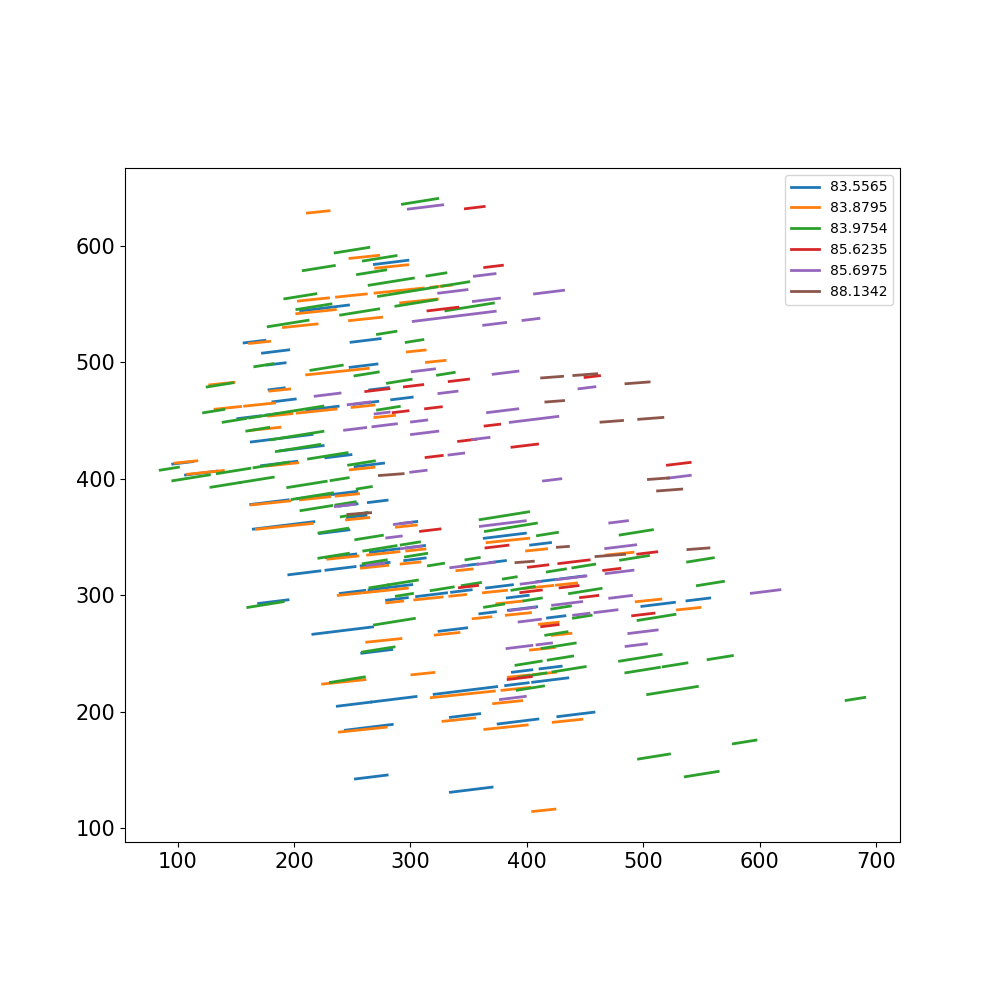

In [10]:
fig,ax = plt.subplots(1,1,figsize=[10,10])
colors = ['C' + str(i) for i in list(range(len(grps_L)))]
for color, (name,grp) in zip(colors,grps_L):
    draw_enface_dt(vis,ax,grp,496,P,color)
ax.set_aspect('equal')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0],[0],color = color) for color in colors]
plt.legend(legend_elements,grps_L.groups.keys())


### Original IR 

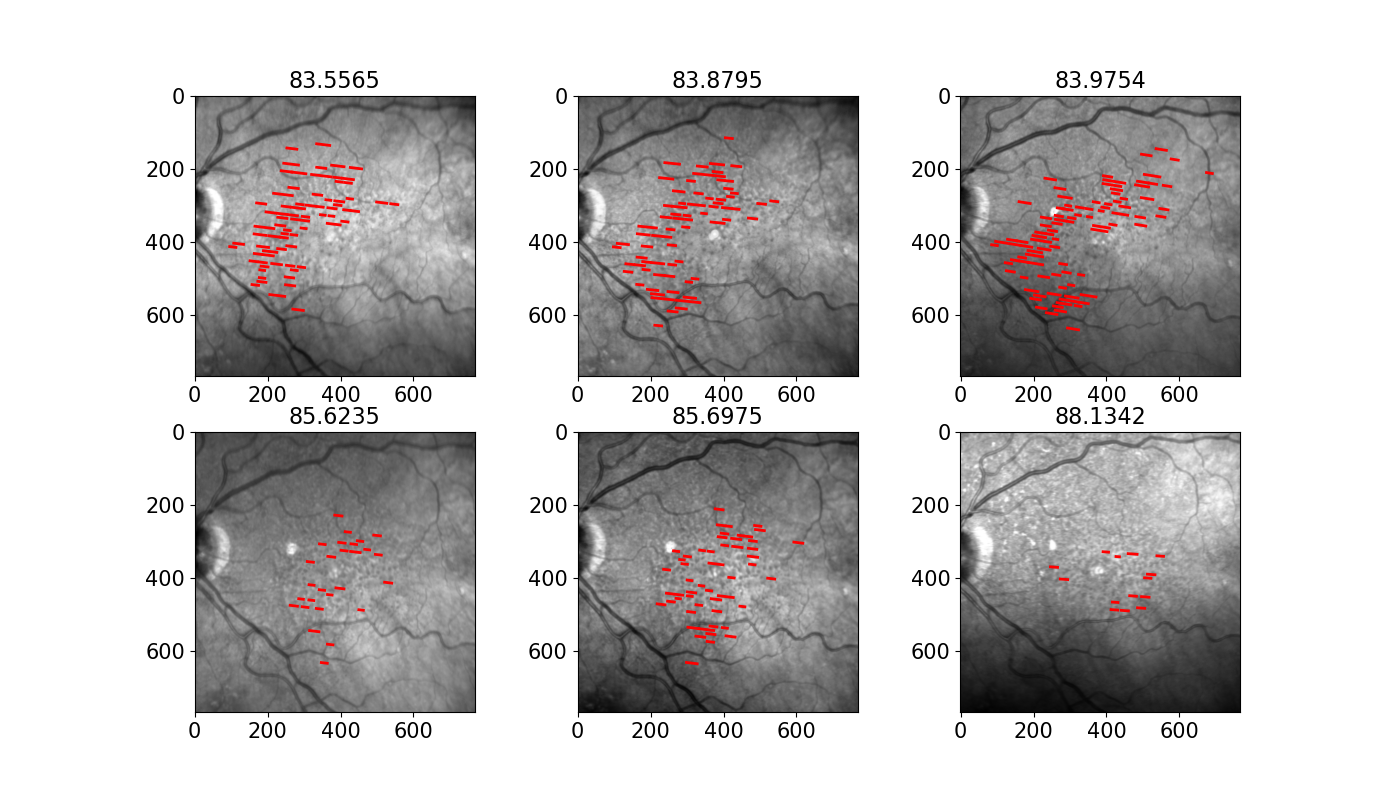

In [18]:
from PIL import Image
fig,axs = plt.subplots(2,3,figsize=[14,8])
irpaths = dict()
for ax,(name,grp) in zip(fig.axes,grps_L):
    dat = vis.get_gt_image_data(grp.index.values[0])
    irpath = os.path.join(os.path.dirname(dat['file_name']),'ir.png')
    irpaths[name] = irpath
    ax.imshow(Image.open(irpath),cmap='gray')
    ax.set_title(name)
    
    draw_enface_dt(vis,ax,grp,496,P,'r')


### Aligned IRs

In [ ]:
import cv2
import numpy as np

def find_affine_matrix(ref_img_path,img_path):
    # Read the images to be aligned
    im1 = cv2.imread(ref_img_path) # Reference image. 
    im2 = cv2.imread(img_path)    # Image to be aligned.

    # Convert images to grayscale
    im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

    # Find size of image1
    sz = im1.shape

    # Define the motion model
    warp_mode = cv2.MOTION_AFFINE 

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 500;

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10;

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)

 
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        # Use warpPerspective for Homography
        im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else:
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

    return im2_aligned,warp_matrix


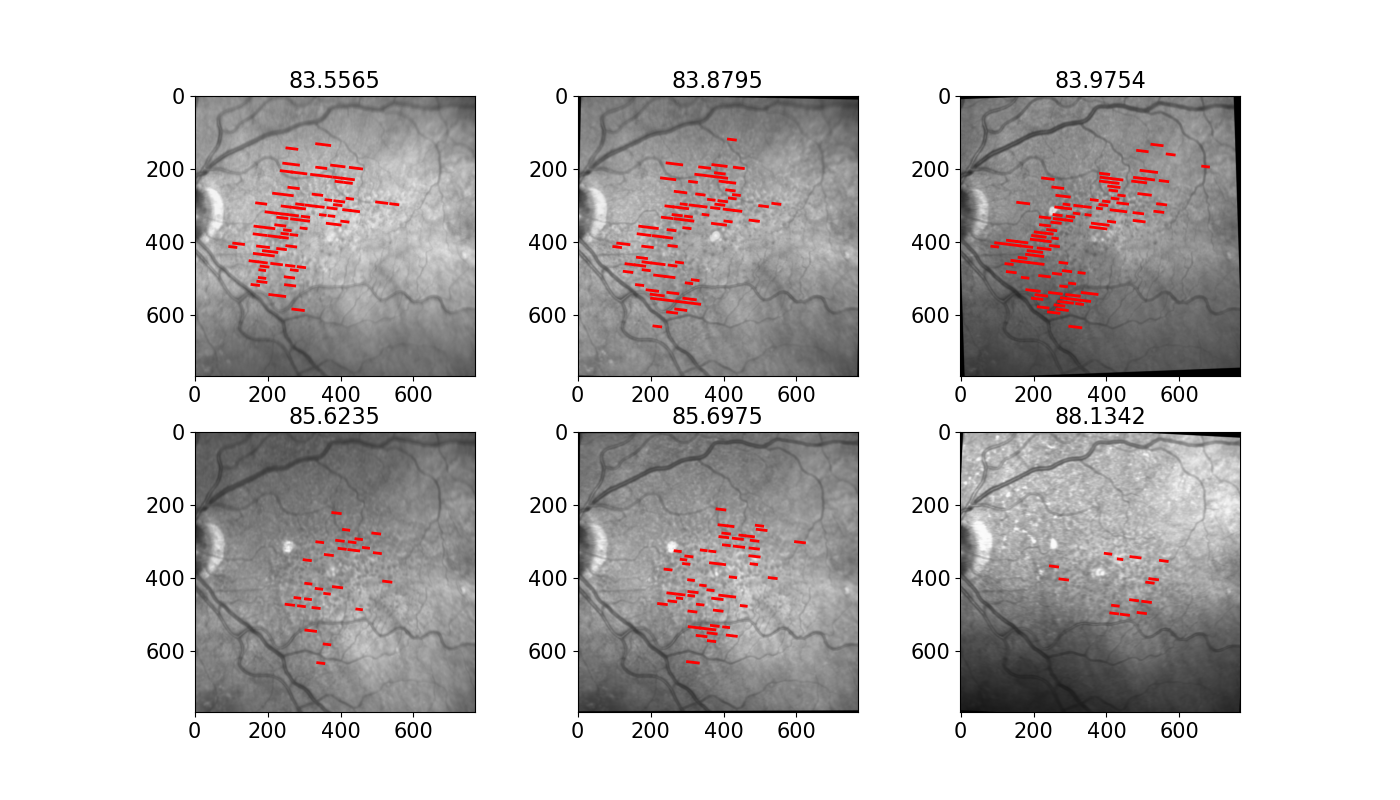

In [26]:
ref_name = 83.5565
affine_transforms = dict()
fig,axs = plt.subplots(2,3,figsize=[14,8])
for ax,(name,grp) in zip(fig.axes,grps_L):
    img,affine_matrix = find_affine_matrix(irpaths[ref_name],irpaths[name])
    affine_transforms[name] = cv2.invertAffineTransform(affine_matrix)
    ax.imshow(img,cmap='gray')
    ax.set_title(name)
    
    draw_enface_dt(vis,ax,grp,496,P,'r',cv2.invertAffineTransform(affine_matrix))


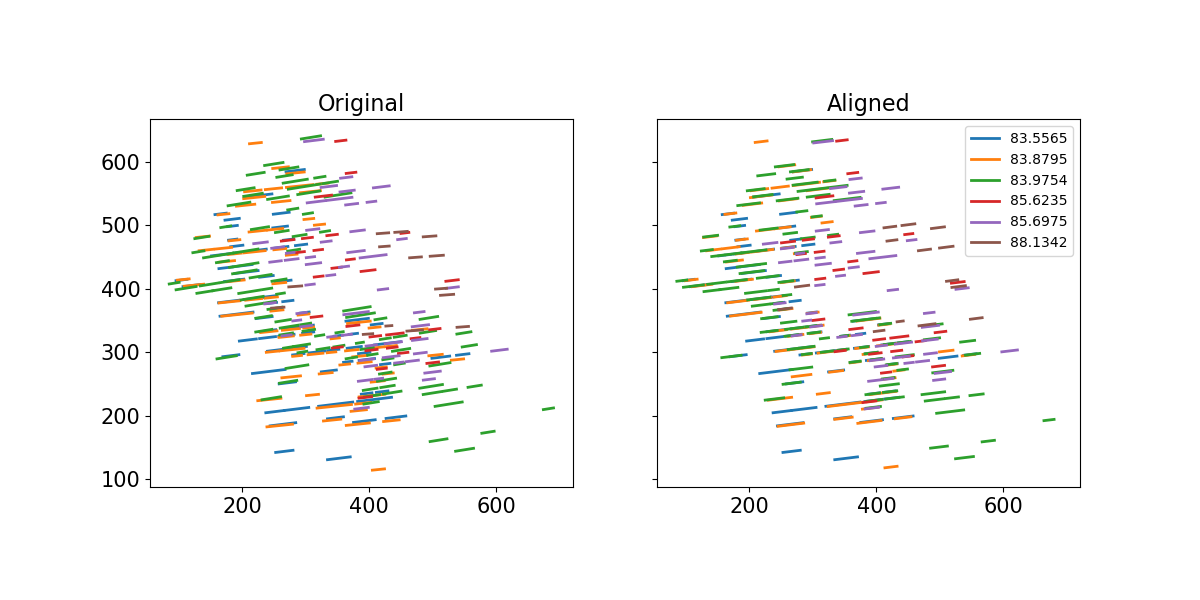

In [31]:
fig,ax = plt.subplots(1,2,figsize=[12,6],sharex=True,sharey=True)
colors = ['C' + str(i) for i in list(range(len(grps_L)))]
for color, (name,grp) in zip(colors,grps_L):
    draw_enface_dt(vis,ax[0],grp,496,P,color)
    draw_enface_dt(vis,ax[1],grp,496,P,color,affine_transforms[name])
ax[0].set_aspect('equal')
ax[0].set_title('Original')
ax[1].set_aspect('equal')
ax[1].set_title('Aligned')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0],[0],color = color) for color in colors]
plt.legend(legend_elements,grps_L.groups.keys())

In [54]:

grps_L.get_group(83.5565)

gt_instances  gt_pxs  \
index                                                                      
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...           0.0     0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...           0.0     0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...           0.0     0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...           0.0     0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...           0.0     0.0   
...                                                          ...     ...   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...           0.0     0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...           0.0     0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...           0.0     0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...           0.0     0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...           0.0     0.0   

                                                    gt_xpxs  dt_instances  \
index                                                                       
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...      0.0           0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...      0.0           0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...      0.0           0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...      0.0           0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...      0.0           0.0   
...                                                     ...           ...   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...      0.0           0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...      0.0           0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...      0.0           0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...      0.0           0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...      0.0           0.0   

                                                    dt_pxs  dt_xpxs  \
index                                                                 
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...     0.0      0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...     0.0      0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...     0.0      0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...     0.0      0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...     0.0      0.0   
...                                                    ...      ...   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...     0.0      0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...     0.0      0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...     0.0      0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...     0.0      0.0   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...     0.0      0.0   

                                                                                                volID  \
index                                                                                                   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...  de3dac267ce106f8599735c1f7b1f4d8a181b11579a3cc...   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...  de3dac267ce106f8599735c1f7b1f4d8a181b11579a3cc...   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...  de3dac267ce106f8599735c1f7b1f4d8a181b11579a3cc...   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...  de3dac267ce106f8599735c1f7b1f4d8a181b11579a3cc...   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...  de3dac267ce106f8599735c1f7b1f4d8a181b11579a3cc...   
...                                                                                               ...   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...  de3dac267ce106f8599735c1f7b1f4d8a181b11579a3cc...   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...  de3dac267ce106f8599735c1f7b1f4d8a181b11579a3cc...   
de3dac267ce106f8599735c1f7b1f4d8a181b11579a3ccd...  de3dac267ce106f8599735c1f7b1f4d8a18

In [21]:
import json
dd = json.load(open('/data/oct-heyex-data/macoct/477daf788b31a095c03f5846a5e738dc4800bd8a6679e301b68c051505648b8d/macOCT/46815cc74787ecb5861ee4886f2842f10cba39bd4bf8678bfa42cd5274ca8f4d/oct.json','r'))

In [22]:
dd

{'ptid': '477daf788b31a095c03f5846a5e738dc4800bd8a6679e301b68c051505648b8d',
 'study': 'OCT',
 'series': 'Volume IR',
 'age': 85.6235,
 'laterality': 'L',
 'instance': 'f497b4bb440f5ac9d676aea3dd7d44bbbc45e369cfe087efcd6ab22979416c14',
 'thickness': 0.118858,
 'res1': 0.003872,
 'res2': 0.011055,
 'type': 'OCT',
 'octh': [[651.5513305664062,
   -14.063793182373047,
   739.831787109375,
   723.0916748046875],
  [641.2103881835938,
   -12.889713287353516,
   729.4908447265625,
   724.2657470703125],
  [630.8695068359375,
   -11.715608596801758,
   719.1499633789062,
   725.4397583007812],
  [620.528564453125,
   -10.541626930236816,
   708.8090209960938,
   726.6138305664062],
  [610.1876220703125, -9.367523193359375, 698.468017578125, 727.7879028320312],
  [599.8466796875, -8.19349193572998, 688.1271362304688, 728.9619750976562],
  [589.5057373046875,
   -7.019412994384766,
   677.7861938476562,
   730.1360473632812],
  [579.164794921875, -5.845382213592529, 667.4452514648438, 731.31011

In [12]:
def plot_enface_long(grps,lat_str):
    fig,axs = plt.subplots(2,3,figsize=[20,16])

    for ax,(name,grp) in zip(fig.axes,grps):
        grp = grps.get_group(name).sort_index()
        enface = vis.get_enface_dt(grp,496,P,dpx)
        ax.imshow(enface)
        ax.set_title(str(name))
    fig.suptitle(ptid+' '+lat_str)
    return fig,axs

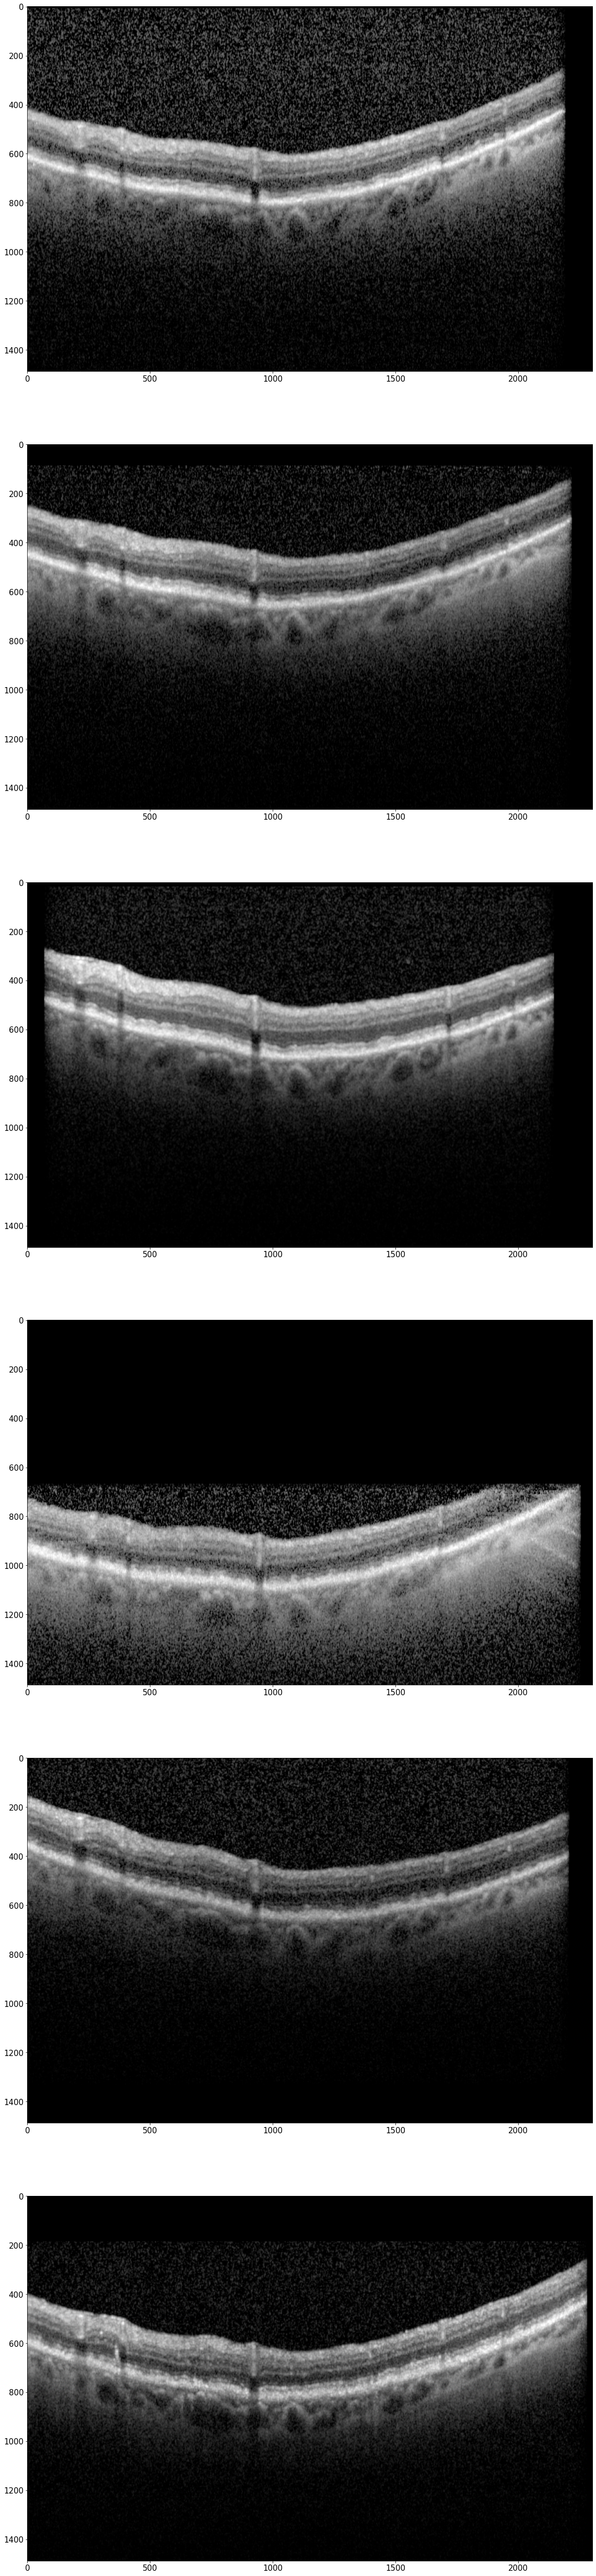

In [53]:
def plot_scans_long(grps,scan):
    fig,axs = plt.subplots(6,1,figsize=[30,90])


    for ax, (name,grp) in zip(fig.axes,grps):
        grp = grps.get_group(name)
        dat = grp[grp['scan']==scan]
        img,img_model = vis.get_image(dat.index)
        ax.imshow(np.array(img_model))
        ax.set_title(str(name))


plot_scans_long(grps_L,60)    

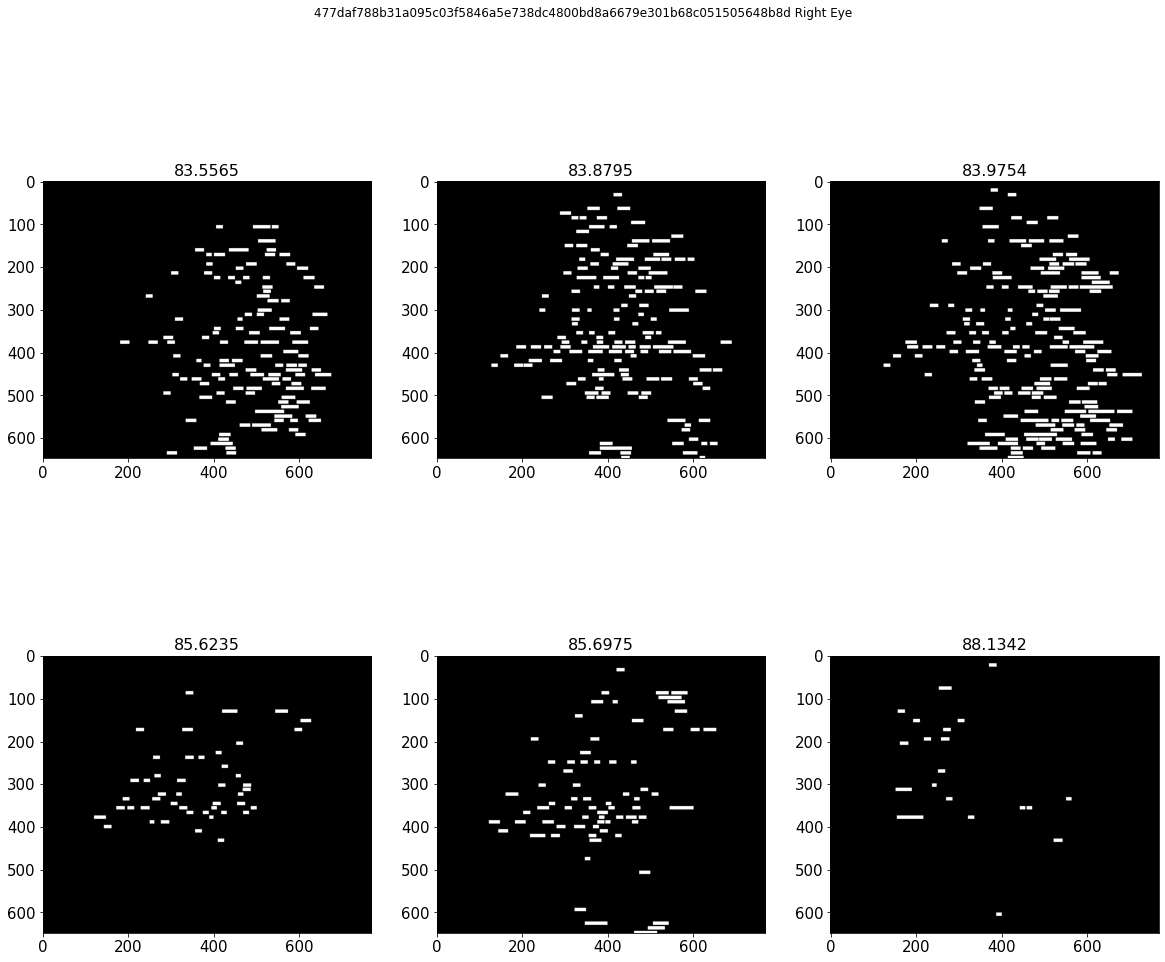

In [13]:
plot_enface_long(grps_R,'Right Eye');

(<Figure size 1440x1152 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'83.5565'}>,
         <AxesSubplot:title={'center':'83.8795'}>,
         <AxesSubplot:title={'center':'83.9754'}>],
        [<AxesSubplot:title={'center':'85.6235'}>,
         <AxesSubplot:title={'center':'85.6975'}>,
         <AxesSubplot:title={'center':'88.1342'}>]], dtype=object))

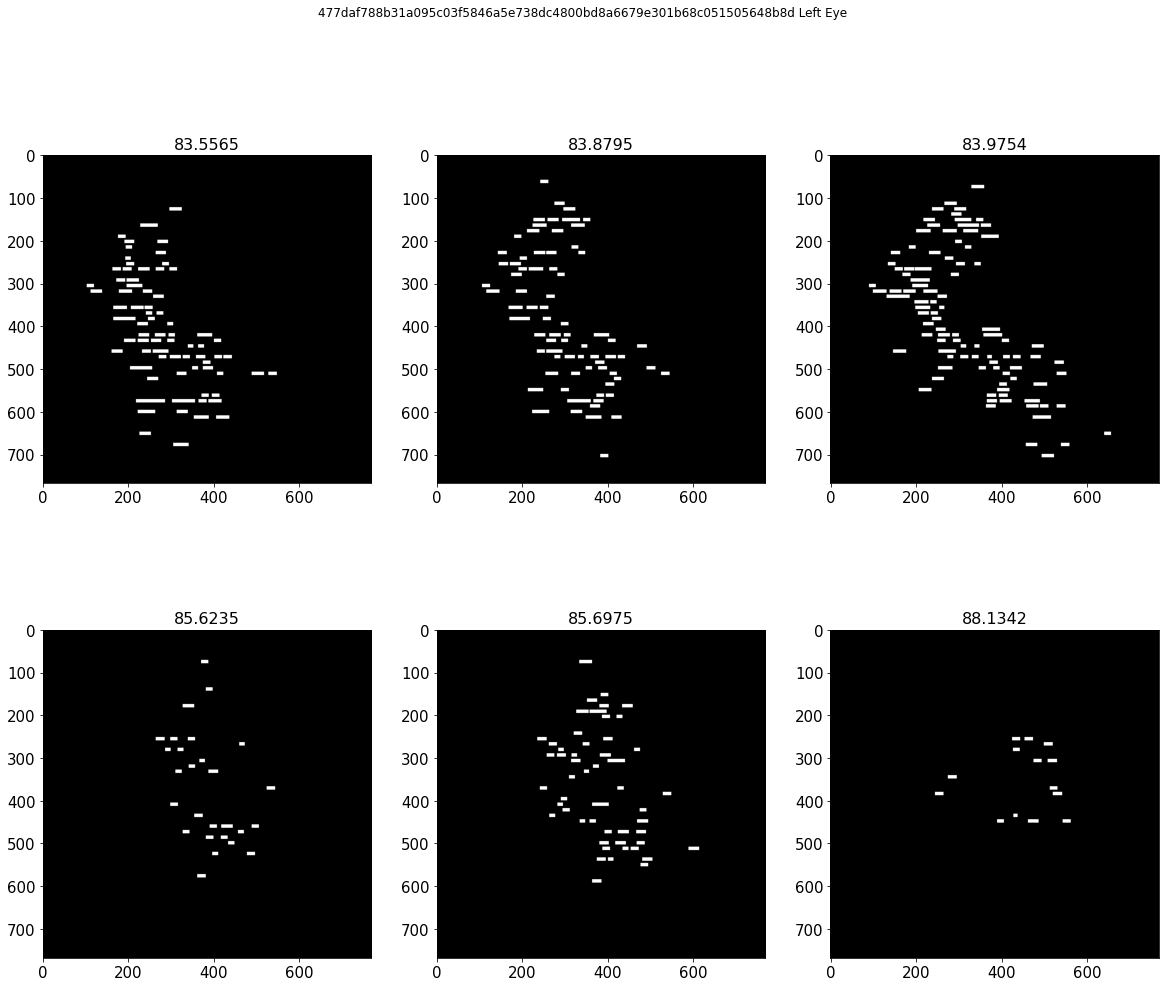

In [36]:
plot_enface_long(grps_L,'Left Eye');

In [41]:
grp

gt_instances  gt_pxs  \
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...           0.0     0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...           0.0     0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...           0.0     0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...           0.0     0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...           0.0     0.0   
...                                                          ...     ...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...           0.0     0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...           0.0     0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...           0.0     0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...           0.0     0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...           0.0     0.0   

                                                    gt_xpxs  dt_instances  \
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...      0.0           0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...      0.0           0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...      0.0           0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...      0.0           0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...      0.0           0.0   
...                                                     ...           ...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...      0.0           1.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...      0.0           1.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...      0.0           2.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...      0.0           2.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...      0.0           0.0   

                                                    dt_pxs  dt_xpxs  \
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...     0.0      0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...     0.0      0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...     0.0      0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...     0.0      0.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...     0.0      0.0   
...                                                    ...      ...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...    87.0     21.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...   287.0     49.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...   266.0     47.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...   244.0     42.0   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...     0.0      0.0   

                                                                                                volID  \
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...  0163b70fd4557b7682d1da13a88d3917b8876164c18049...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...  0163b70fd4557b7682d1da13a88d3917b8876164c18049...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...  0163b70fd4557b7682d1da13a88d3917b8876164c18049...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...  0163b70fd4557b7682d1da13a88d3917b8876164c18049...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...  0163b70fd4557b7682d1da13a88d3917b8876164c18049...   
...                                                                                               ...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...  0163b70fd4557b7682d1da13a88d3917b8876164c18049...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...  0163b70fd4557b7682d1da13a88d3917b8876164c18049...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...  0163b70fd4557b7682d1da13a88d3917b8876164c18049...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...  0163b70fd4557b7682d1da13a88d3917b8876164c18049...   
0163b70fd4557b7682d1da13a88d3917b8876164c18049b...  0163b70fd4557b7682d1da13a88d3917b8876164c18049...   

                                                    scan  
0163b70fd4557b7682d1da13a88d3917b8876164c

## Example for ARVO 2022

In [ ]:
vis =OutputVis(dataset_name,pred_mode='file',pred_file = 'output_test/coco_instances_results.json')
gt,dt = vis.get_image('101109_OD_oct-033.png')
ori = vis.get_ori_image('101109_OD_oct-033.png')
from PIL import Image
hcrange = list(vis.height_crop_range(np.array(ori.convert('L')),height_target=256*3))

im = Image.fromarray(np.concatenate((np.array(ori.convert('RGB'))[hcrange,:],np.array(gt)[hcrange,:],np.array(dt)[hcrange])))
im.save('output_test/101109_OD_oct-033.jpg')